In [ ]:
!pip install nibabel SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 45.7 MB/s eta 0:00:00


QALAS Verisi Yüklendi. Orijinal Boyut (HR): (192, 168, 56, 5)


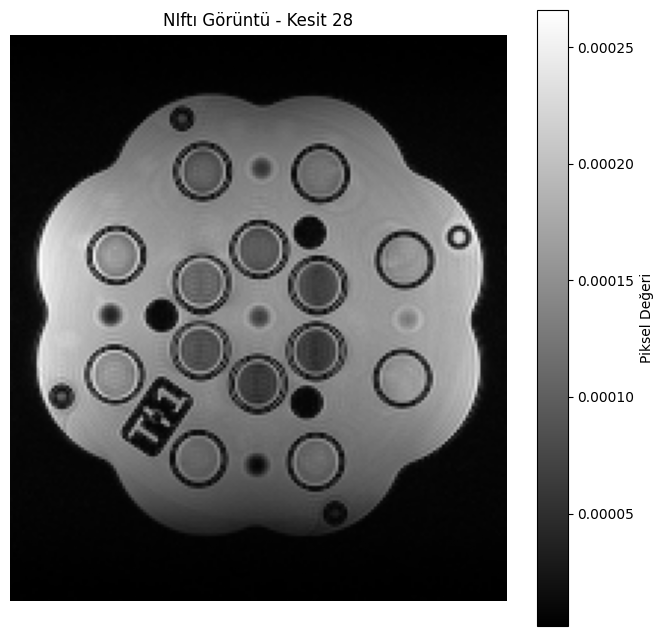

In [ ]:
# PHANTOM GÖRÜNTÜLEME
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# phantom dosya yolu
qalas_path = '/content/drive/MyDrive/img_qalas.nii'

try:
    qalas_img = nib.load(qalas_path)
    qalas_data = qalas_img.get_fdata().astype(np.float32)
    print(f"QALAS Verisi Yüklendi. Orijinal Boyut (HR): {qalas_data.shape}")
except Exception as e:
    print(f"HATA: QALAS dosyası yüklenemedi. Kontrol edin. Hata: {e}")

except FileNotFoundError:
    print(f"HATA: Dosya bulunamadı. Lütfen yolun doğru olduğundan emin olun: {file_path}")
except Exception as e:
    print(f"Bir hata oluştu: {e}")

if qalas_data.ndim >= 3:
  #genelde medikal görüntüler üç boyuludur.
  #z eksenindeki orta kesiti hesapla
  slice_idx = qalas_data.shape[2] // 2

  #kesiti aldıktan sonra veri dört boyutlu olduğu için
  #4. boyut olan kanalı da seçiyoruz.
  slice_data = qalas_data[:, :, slice_idx, 0]

  plt.figure(figsize=(8,8))
  plt.imshow(slice_data, cmap="gray")
  plt.title(f"NIftı Görüntü - Kesit {slice_idx}")
  plt.colorbar(label="Piksel Değeri")
  plt.axis("off")
  plt.show()
else:
  print("görüntüleme için yeterli boyut yok")

In [ ]:
%%capture
!pip install nibabel SimpleITK  monai torch torchvision tqdm --quiet torchmetrics --quiet

PeakSignalNoiseRatio (PSNR)

Görüntü kalitesini sayısal olarak ölçer

Süper çözünürlükte:

Üretilen görüntü, orijinal (ground truth) görüntüye ne kadar yakın?

Büyük PSNR → daha iyi kalite

Gürültüye duyarlıdır

🔹 StructuralSimilarityIndexMeasure (SSIM)

İnsan gözüne benzer şekilde yapısal benzerliği ölçer

Parlaklık, kontrast ve yapı bilgisini birlikte değerlendirir

MRI gibi medikal görüntülerde PSNR’den daha anlamlıdır

Kısaca:

PSNR = matematiksel benzerlik
SSIM = algısal / yapısal benzerlik

##3D U-NET Tabanlı Derin Öğrenme Modeli

In [ ]:
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

import numpy as np
import torch #pytorch'un çekirdeği, tensör işlemleri, gpu-cpu yönetimi, oto türev (backpropagation)
import torch.nn as nn #sinir ağı katmanları conv3d, ReLI, MSELoss, Sequential model mimarisini inşa etmek için
from torch.utils.data import Dataset, DataLoader
#dataset: verinin nasıl yükleneceği, nii dosyasını oku, normalize et, tensor'a çevşr
#dataloader: veriyi batchlere böler, shuffle eder, GPU'ya verimli aktarır
from monai.networks.nets import UNet #monai medikal görüntüle için özelleşmiş PyTorch kütüphanesi
#U-Net: Medikal görüntülerde: Segmentasyon, Süper Çözünürlük, Gürültü alatma
from monai.transforms import ScaleIntensityRange #görüntü yoğunluklarını belirli bir aralığa ölçekler
#Farklı taramalardaki intensity farklarını azaltır. Modelin daha stabil öğrenmesini sağlar
from tqdm.notebook import tqdm #eğitim sırasında ilerleme çubuğu, notebook uyumlu versiyon
import os

#cihaz ayarı, GPU varsa kullan, yoksa CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

#global ölçeklendirme fonksiyonu. 4x downsampling ile LR oluşturma
DS_FACTOR = 4

def downsample_volume(volume, factor=4):
  """Hacmi 3D olarak bir faktör kadar downsample eder."""
  x_size, y_size, z_size = volume.shape[:3]
  lr_volume = volume[::factor, ::factor, ::factor]
  return lr_volume
# 2. Normalizasyon (0-1 aralığına)
data_min = qalas_data.min()
data_max = qalas_data.max()
hr_volume = (qalas_data - data_min) / (data_max - data_min)

# Multi-Kanal Kontrolü ve Tek Kanal Seçimi
if hr_volume.ndim == 4:
    hr_volume = hr_volume[..., 0]
    print(f"Not: 4D veriden sadece ilk kanal alındı. Yeni Boyut: {hr_volume.shape}")

# 3. Eğitim Subset'i Oluşturma (64x64x64 HR Crop)
# ---------------- SR İÇİN KRİTİK ADIM: BOYUTU SABİTLEME ----------------

H, W, D = hr_volume.shape
CROP_SIZE = 64 # Hedef boyut

center = (H//2, W//2, D//2)

# Kırpma: Sınırları aşmayan bir bölge al
x_start = max(center[0] - CROP_SIZE//2, 0)
x_end = min(center[0] + CROP_SIZE//2, H)
y_start = max(center[1] - CROP_SIZE//2, 0)
y_end = min(center[1] + CROP_SIZE//2, W)
z_start = max(center[2] - CROP_SIZE//2, 0)
z_end = min(center[2] + CROP_SIZE//2, D)

hr_crop = hr_volume[x_start:x_end,
                    y_start:y_end,
                    z_start:z_end]

# Boyutlandırma (Padding) Kontrolü
pad_x = CROP_SIZE - hr_crop.shape[0]
pad_y = CROP_SIZE - hr_crop.shape[1]
pad_z = CROP_SIZE - hr_crop.shape[2]

# Doldurma (Padding): Eksik kalan boyutları 0 ile tamamla
# (0, pad_x) -> x ekseninde başta 0, sonda pad_x kadar doldur
hr_crop_padded = np.pad(hr_crop,
                        ((0, pad_x), (0, pad_y), (0, pad_z)),
                        mode='constant',
                        constant_values=0)

# 4. LR Crop (16x16x16) - SR GÖREVİ İÇİN GEREKLİ
lr_crop = downsample_volume(hr_crop_padded, factor=DS_FACTOR)

# 5. PyTorch formatına dönüştürme (Batch, Channel, Depth, Height, Width)
# lr_tensor: (1, 1, 16, 16, 16)
# hr_tensor: (1, 1, 64, 64, 64)
lr_tensor = torch.tensor(lr_crop[np.newaxis, np.newaxis, ...], dtype=torch.float32)
hr_tensor = torch.tensor(hr_crop_padded[np.newaxis, np.newaxis, ...], dtype=torch.float32)

print(f"Eğitim Input (LR) Shape: {lr_tensor.shape}")
print(f"Eğitim Target (HR) Shape: {hr_tensor.shape}")

# 6. GPU'ya taşı
lr_input = lr_tensor.to(device)
hr_target = hr_tensor.to(device)

print(f"\nVeriler başarıyla {device}'a taşındı. Prototip modeli eğitime hazır.")
print(f"Tüm Input/Target boyutları ({CROP_SIZE // DS_FACTOR}x{CROP_SIZE // DS_FACTOR}x{CROP_SIZE // DS_FACTOR}) vs ({CROP_SIZE}x{CROP_SIZE}x{CROP_SIZE}) olarak ayarlandı.")

Kullanılan cihaz: cuda
Not: 4D veriden sadece ilk kanal alındı. Yeni Boyut: (192, 168, 56)
Eğitim Input (LR) Shape: torch.Size([1, 1, 16, 16, 16])
Eğitim Target (HR) Shape: torch.Size([1, 1, 64, 64, 64])

Veriler başarıyla cuda'a taşındı. Prototip modeli eğitime hazır.
Tüm Input/Target boyutları (16x16x16) vs (64x64x64) olarak ayarlandı.


In [ ]:
#model tanımı
# 1. Model Tanımı (3D U-Net)
# spatial_dims=3 (3D), in_channels=1 (tek QALAS), out_channels=1
# channels: Her seviyedeki feature map sayısı
# strides: Downsampling (pooling) adımları

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=[16, 32, 64],   # Daha az derinlik
    strides=[2, 2],          # Daha az downsampling
    num_res_units=2,
).to(device)


print("3D U-Net Prototipi Başarıyla Kuruldu.")

# 2. Loss Fonksiyonu (Basit L1 Loss)
criterion = nn.L1Loss() #  L1/L2 loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Verileri GPU'ya taşı
lr_input = lr_tensor.to(device)
hr_target = hr_tensor.to(device)

# Eğitim Ayarları
num_epochs = 20 # Sadece pipeline'ı test etmek için az sayıda epoch
loss_history = []
print(f"Eğitime Başlanıyor ({num_epochs} Epoch)...")
model.train()
for epoch in tqdm(range(num_epochs)):
    # 1. Sıfırla
    optimizer.zero_grad()

    # 2. Forward Pass
    # NOT: U-Net yapısı gereği, girişi (16x16x16) alacak ve çıkışı (16x16x16) boyutunda olacaktır.
    # Ancak Süper Çözünürlük için U-Net'in Genişleme (Up-sampling) yolunda
    # `Subpixel Convolution` veya `Interpolation` kullanılarak
    # Çözünürlüğün HR (64x64x64) boyutuna çıkarılması gerekir.
    # MONAI U-Net'i standart segmentasyon için tasarlandığından, SR için ya özelleştirilmeli ya da
    # girişi HR boyutunda olmalıdır.

    # Girişi (1, 1, 16, 16, 16) modelleyelim
    output_lr = model(lr_input)

    # Gerçek SR için: LR'ı 4x büyütmek ve HR target (64x64x64) ile kıyaslamak gerekir.
    # Bu prototipte, 3D U-Net'i **girişi (16^3) alıp çıkışı 4x büyütülmüş (64^3) olarak** vermesi için özelleştirmemiz gerekir.

    output_hr = model(hr_target) # HR'ı input ver, HR'ı output bekle (Denoising)
    loss = criterion(output_hr, hr_target) # HR'ı HR'a benzet

    # 3. Backward Pass ve Optimizasyon
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # Raporlama
    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

print("Eğitim Testi Başarıyla Tamamlandı.")


3D U-Net Prototipi Başarıyla Kuruldu.
Eğitime Başlanıyor (20 Epoch)...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.468202
Epoch [10/20], Loss: 0.366252
Epoch [15/20], Loss: 0.314139
Epoch [20/20], Loss: 0.283466
Eğitim Testi Başarıyla Tamamlandı.


##PREDİCTİON

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(



Model Çıktısı Sonuçları:
PSNR (Gürültüye Oran): 6.4222
SSIM (Yapısal Benzerlik): 0.0172


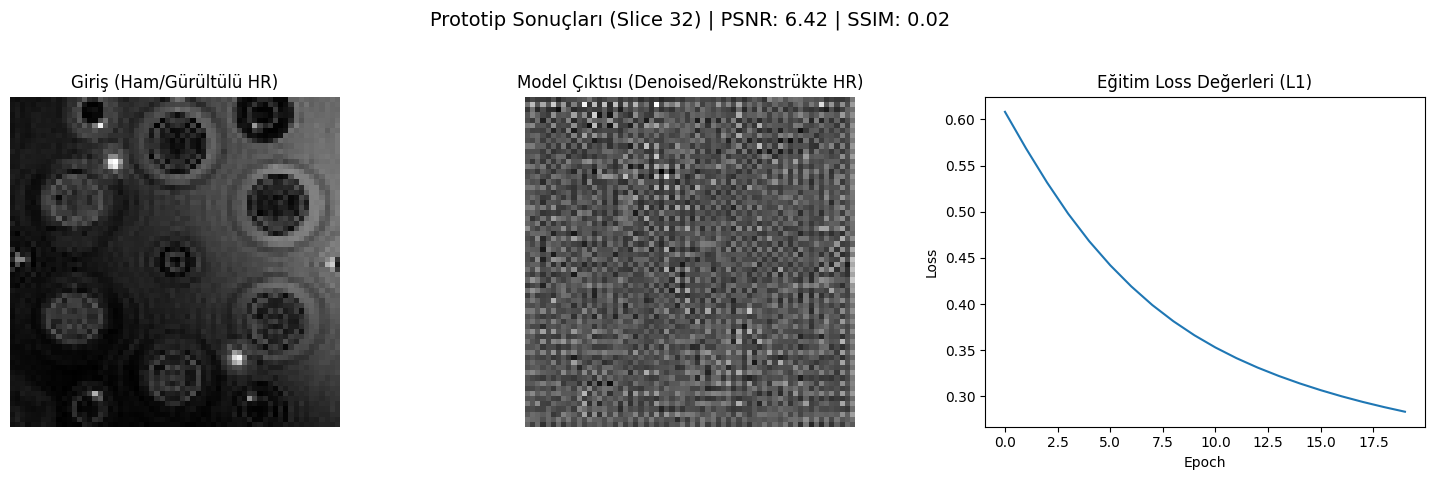

In [ ]:
model.eval()
with torch.no_grad():
  predicted_hr_tensor = model(hr_target)

psnr = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Metricleri update et
psnr.update(predicted_hr_tensor, hr_target)  # ikisi de GPU'da
ssim.update(predicted_hr_tensor, hr_target)

# Compute et
mean_psnr = psnr.compute().item()
mean_ssim = ssim.compute().item()

print(f"\nModel Çıktısı Sonuçları:")
print(f"PSNR (Gürültüye Oran): {mean_psnr:.4f}")
print(f"SSIM (Yapısal Benzerlik): {mean_ssim:.4f}")

# Görselleştirme için CPU'ya taşı
pred_cpu = predicted_hr_tensor.cpu()
hr_cpu = hr_target.cpu()
slice_idx = hr_cpu.shape[4] // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Prototip Sonuçları (Slice {slice_idx}) | PSNR: {mean_psnr:.2f} | SSIM: {mean_ssim:.2f}", fontsize=14)

axes[0].imshow(hr_cpu[0, 0, :, :, slice_idx].numpy(), cmap='gray')
axes[0].set_title('Giriş (Ham/Gürültülü HR)')
axes[0].axis('off')

axes[1].imshow(pred_cpu[0, 0, :, :, slice_idx].numpy(), cmap='gray')
axes[1].set_title('Model Çıktısı (Denoised/Rekonstrükte HR)')
axes[1].axis('off')

axes[2].plot(loss_history)
axes[2].set_title('Eğitim Loss Değerleri (L1)')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Özel 3D Çözünürlük Ağı

Girişin:
64 × 64 × 64 × 1 kanal

Encoder Seviye 1
64 × 64 × 64
8 kanal


Aynı görüntü, 8 farklı filtreyle görülüyor

Encoder Seviye 2 (stride=2)
32 × 32 × 32
16 kanal


Görüntü küçüldü ama bilgi türü arttı

Encoder Seviye 3
16 × 16 × 16
32 kanal

Encoder Seviye 4
8 × 8 × 8
64 kanal


 Alan küçülür, anlam artar

Encoder’da görüntü küçülürken, kanal sayısı artar çünkü model uzamsal detay yerine anlam öğrenir.

In [23]:
class SuperResolutionUNet(nn.Module):
  """
    3D MRI Süper Çözünürlük için:
    - U-Net: Feature extraction (çözünürlük artırmaz)
    - ConvTranspose3d: Öğrenilebilir upsampling (SR)
  """
  #Özellik çıkarımı ve kıyaslama için MONAI U-Net
  # U-Net, 16x16x16 girişi alıp, aynı boyutta (ancak daha rafine) özellikler çıkaracaktır.
  #Buradaki U-Net doğrudan çözünürlük büyütmez, özellik çıkarır
  def __init__(self,in_channels, out_channels, scale_factor):
    super().__init__()
    self.unet = UNet( #Monai'n,n medikal görüntüler için optimize edilmiş U-Net'i
        spatial_dims=3, #3 boyutlu (x,y,z)
        in_channels=in_channels, #genelde 1 ama bizim durumumuzda 5
        out_channels=32,
        channels=(16, 32, 64, 128), #daha hafif bir UNet yapısı, hız için
                      #her seviyede kaç feature öğreneceğinin katman katman yazılımı
        strides=(1,1,1),
        num_res_units=2,#daha stabil öğrenme
        norm='batch'
    )

    #Süper çözünürlük katmanı
    #ConvTranspose3d (Deconvolution) veya Basit Upsampling kullanılabilir
    #convtranspose 3d, öğrenilebilir parametreler içeriği için daha önemli
    """    self.upsample_layer=nn.ConvTranspose3d(
        in_channels=32,
        out_channels=out_channels,
        kernel_size=scale_factor,
        stride=scale_factor,
        padding=0 #kenarlara ekstra boşluk eklenmiyor
    )"""
    self.upsample_layer = nn.Sequential(
      nn.Upsample(scale_factor=scale_factor, mode="trilinear", align_corners=False),
      nn.Conv3d(32, out_channels, kernel_size=3, padding=1)
    )

    #normal convalution görüntüyü küçülyüt
    #convtranspose3d büyütür, bilgiyi yayr
    #f.interpolation(mode="trilinear")'dan farkı öğrenilebilir, içeriğe göre büyütür, kenarları dokuyu korur
    #U-Net ne çizeceğini ConvTranspose nasıl büyüteceğini öğrenir.

    self.refine = nn.Sequential(
        nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
    )
    self.output_act = nn.Sigmoid()
  def forward(self, x):
    x_features = self.unet(x)
    #özellik çıkarımı
    sr = self.upsample_layer(x_features)
    sr = self.refine(sr)
    sr = self.output_act(sr)
    return sr

model = SuperResolutionUNet(
    in_channels = 1,
    out_channels = 1,
    scale_factor = DS_FACTOR
).to(device)

# Verileri GPU'ya taşı
lr_input = lr_tensor.to(device)
hr_target = hr_tensor.to(device)

# Eğitim Ayarları
num_epochs = 500
loss_history = []


criterion = nn.SmoothL1Loss(beta=0.01)

optimizer=torch.optim.Adam(model.parameters(), lr=5e-5)


print(f"Eğitime Başlanıyor ({num_epochs} Epoch)...")

model.train()
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    # 1. Forward Pass: LR Input -> HR Output
    predicted_hr = model(lr_input)

    # 2. Loss Hesaplama: HR Output vs HR Target (Kritik)
    loss = criterion(predicted_hr, hr_target)

    # 3. Backward Pass
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

print("Eğitim Testi Başarıyla Tamamlandı.")

Eğitime Başlanıyor (500 Epoch)...


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/500], Loss: 0.320810
Epoch [10/500], Loss: 0.319997
Epoch [15/500], Loss: 0.319196
Epoch [20/500], Loss: 0.318234
Epoch [25/500], Loss: 0.317000
Epoch [30/500], Loss: 0.315331
Epoch [35/500], Loss: 0.313000
Epoch [40/500], Loss: 0.309634
Epoch [45/500], Loss: 0.304702
Epoch [50/500], Loss: 0.297711
Epoch [55/500], Loss: 0.288124
Epoch [60/500], Loss: 0.275638
Epoch [65/500], Loss: 0.260093
Epoch [70/500], Loss: 0.241848
Epoch [75/500], Loss: 0.220873
Epoch [80/500], Loss: 0.197872
Epoch [85/500], Loss: 0.174498
Epoch [90/500], Loss: 0.151178
Epoch [95/500], Loss: 0.127407
Epoch [100/500], Loss: 0.108687
Epoch [105/500], Loss: 0.095491
Epoch [110/500], Loss: 0.084081
Epoch [115/500], Loss: 0.075393
Epoch [120/500], Loss: 0.069085
Epoch [125/500], Loss: 0.064963
Epoch [130/500], Loss: 0.062527
Epoch [135/500], Loss: 0.061009
Epoch [140/500], Loss: 0.059844
Epoch [145/500], Loss: 0.058912
Epoch [150/500], Loss: 0.058210
Epoch [155/500], Loss: 0.057460
Epoch [160/500], Loss: 0.057

## Model Değerlendirme Fonksiyonu


--- Metrik Sonuçları ---
Model PSNR   : 20.6400
Bicubic PSNR : 18.9842
Model SSIM   : 0.5967
Bicubic SSIM : 0.4915
------------------------


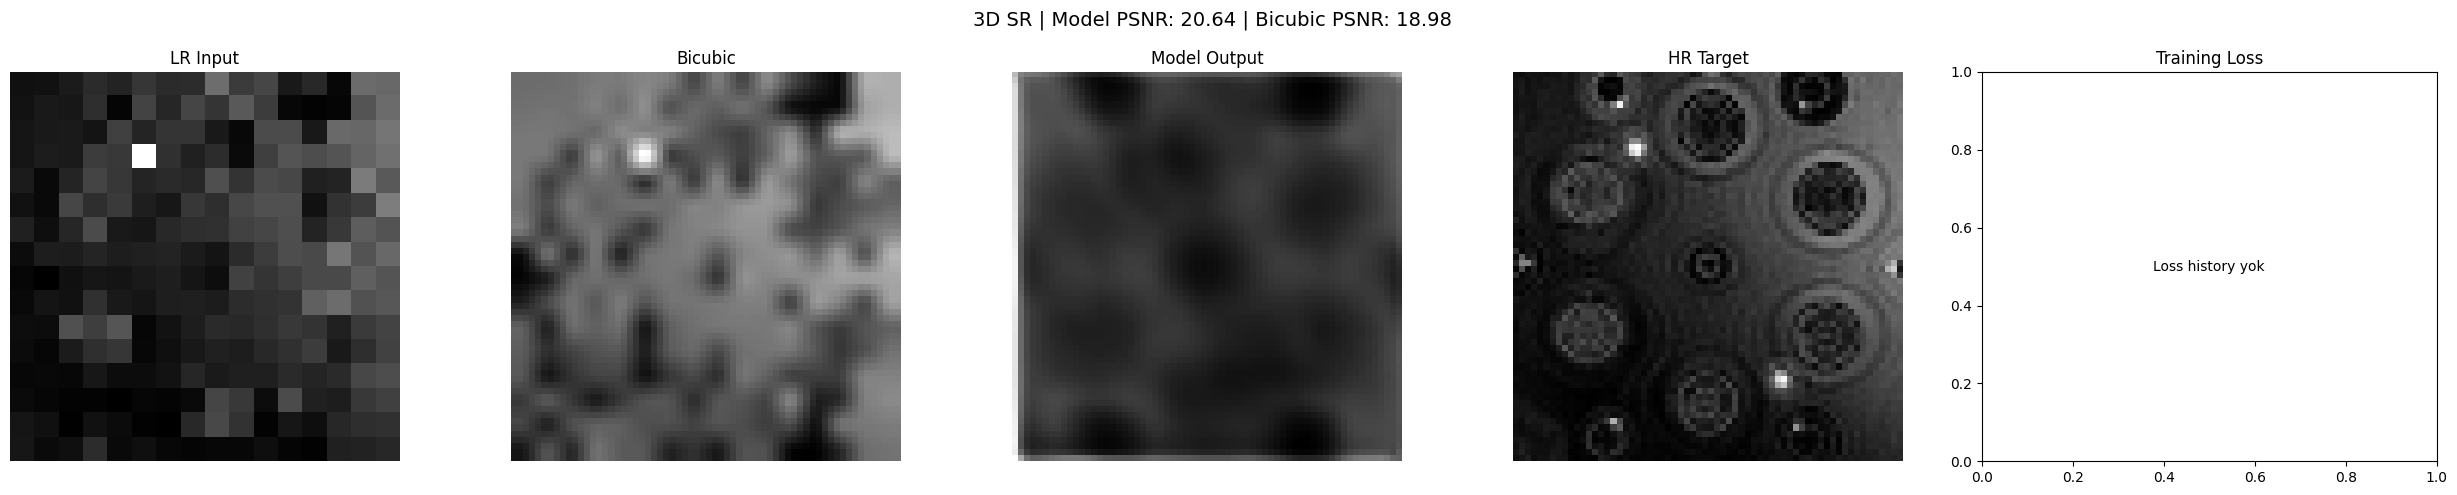

{'model_psnr': 20.639951705932617,
 'model_ssim': 0.5966610908508301,
 'bicubic_psnr': 18.984163284301758,
 'bicubic_ssim': 0.49145907163619995}

In [26]:
def evaluate_sr_model(
    model,
    lr_input,
    hr_target,
    DS_FACTOR,
    device,
    loss_history=None,
    data_range=1.0
):
    import torch
    import torch.nn.functional as F
    import matplotlib.pyplot as plt
    from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

    # -------------------------
    # 1. Model Tahmini
    # -------------------------
    model.eval()
    with torch.no_grad():
        predicted_hr_gpu = model(lr_input)

    predicted_hr = predicted_hr_gpu.cpu()
    hr_cpu = hr_target.cpu()
    lr_cpu = lr_input.cpu()

    # -------------------------
    # 2. Bicubic Upsampling
    # -------------------------
    bicubic_upsampled = F.interpolate(
        lr_cpu,
        scale_factor=DS_FACTOR,
        mode='trilinear',
        align_corners=False
    )

    # -------------------------
    # 3. METRİKLER
    # -------------------------
    psnr = PeakSignalNoiseRatio(data_range=data_range).to(device)
    ssim = StructuralSimilarityIndexMeasure(data_range=data_range).to(device)

    psnr(predicted_hr_gpu, hr_target)
    ssim(predicted_hr_gpu, hr_target)

    model_psnr = psnr.compute().item()
    model_ssim = ssim.compute().item()

    psnr.reset()
    ssim.reset()

    psnr_cpu = PeakSignalNoiseRatio(data_range=data_range)
    ssim_cpu = StructuralSimilarityIndexMeasure(data_range=data_range)

    psnr_cpu(bicubic_upsampled, hr_cpu)
    ssim_cpu(bicubic_upsampled, hr_cpu)

    bicubic_psnr = psnr_cpu.compute().item()
    bicubic_ssim = ssim_cpu.compute().item()

    # -------------------------
    # 4. RAPOR
    # -------------------------
    print("\n--- Metrik Sonuçları ---")
    print(f"Model PSNR   : {model_psnr:.4f}")
    print(f"Bicubic PSNR : {bicubic_psnr:.4f}")
    print(f"Model SSIM   : {model_ssim:.4f}")
    print(f"Bicubic SSIM : {bicubic_ssim:.4f}")
    print("------------------------")

    # -------------------------
    # 5. GÖRSELLEŞTİRME
    # -------------------------
    slice_idx = hr_cpu.shape[-1] // 2

    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    fig.suptitle(
        f"3D SR | Model PSNR: {model_psnr:.2f} | Bicubic PSNR: {bicubic_psnr:.2f}",
        fontsize=14
    )

    axes[0].imshow(lr_cpu[0, 0, :, :, slice_idx // DS_FACTOR], cmap='gray')
    axes[0].set_title("LR Input")
    axes[0].axis('off')

    axes[1].imshow(bicubic_upsampled[0, 0, :, :, slice_idx], cmap='gray')
    axes[1].set_title("Bicubic")
    axes[1].axis('off')

    axes[2].imshow(predicted_hr[0, 0, :, :, slice_idx], cmap='gray')
    axes[2].set_title("Model Output")
    axes[2].axis('off')

    axes[3].imshow(hr_cpu[0, 0, :, :, slice_idx], cmap='gray')
    axes[3].set_title("HR Target")
    axes[3].axis('off')

    if loss_history is not None:
        axes[4].plot(loss_history)
        axes[4].set_title("Training Loss")
        axes[4].set_xlabel("Epoch")
        axes[4].set_ylabel("L1 Loss")
    else:
        axes[4].text(0.5, 0.5, "Loss history yok", ha='center', va='center')
        axes[4].set_title("Training Loss")

    plt.tight_layout()
    plt.show()

    return {
        "model_psnr": model_psnr,
        "model_ssim": model_ssim,
        "bicubic_psnr": bicubic_psnr,
        "bicubic_ssim": bicubic_ssim
    }


evaluate_sr_model(
    model,
    lr_input,
    hr_target,
    4,
    device,
    loss_history=None,
    data_range=1.0
)